<a href="https://colab.research.google.com/github/subhasish52/ML_LAB_TEST/blob/main/ML_LAB_TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [7]:
df=pd.read_csv("/content/loan_data.csv")

In [3]:
df.isna().sum()

,0
id,0
annual_income,0
debt_to_income_ratio,0
credit_score,0
loan_amount,0
interest_rate,0
gender,0
marital_status,0
education_level,0
employment_status,0


In [4]:
df.duplicated().sum()

np.int64(0)

In [5]:
df.head(5)

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1


In [6]:
df['loan_purpose'].values

array(['Other', 'Debt consolidation', 'Debt consolidation', ...,
       'Business', 'Debt consolidation', 'Car'], dtype=object)

In [7]:
df['education_level'].values

array(['High School', "Master's", 'High School', ..., "Bachelor's",
       "Bachelor's", "Master's"], dtype=object)

XGBoost AUC: 0.9198998211503926


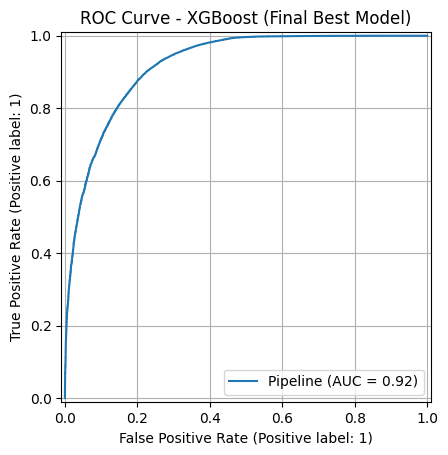

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from xgboost import XGBClassifier
import matplotlib.pyplot as plt


df["grade"] = df["grade_subgrade"].str[0]
df["subgrade_num"] = df["grade_subgrade"].str[1:].astype(int)
df.drop(columns=["id", "grade_subgrade"], inplace=True)


X = df.drop(columns=["loan_paid_back"])
y = df["loan_paid_back"]


cat_cols = ["gender","marital_status","education_level","employment_status","loan_purpose","grade"]
num_cols = ["annual_income","debt_to_income_ratio","credit_score","loan_amount","interest_rate","subgrade_num"]


preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])


xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss"
)

pipeline_xgb = Pipeline([
    ("preprocess", preprocess),
    ("clf", xgb_model)
])


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


pipeline_xgb.fit(X_train, y_train)


preds = pipeline_xgb.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, preds)

print("XGBoost AUC:", auc)


RocCurveDisplay.from_estimator(pipeline_xgb, X_test, y_test)
plt.title("ROC Curve - XGBoost (Final Best Model)")
plt.grid(True)
plt.show()



In [11]:
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

def objective(trial):


    param = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 600),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 3),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "eval_metric": "logloss",
        "n_jobs": -1
    }

    model = XGBClassifier(**param)

    pipe = Pipeline([
        ("preprocess", preprocess),
        ("clf", model)
    ])

    pipe.fit(X_train, y_train)
    preds = pipe.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, preds)
    return auc


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)

print("Best Trial Score (AUC):", study.best_value)
print("Best Params:", study.best_params)


[I 2025-11-28 05:15:20,843] A new study created in memory with name: no-name-d8ef30a5-b135-4239-9e5c-04e7e4f820a2
[I 2025-11-28 05:15:32,286] Trial 0 finished with value: 0.9166747861364082 and parameters: {'n_estimators': 289, 'learning_rate': 0.042776204446527924, 'max_depth': 3, 'subsample': 0.890300015626069, 'colsample_bytree': 0.9964340542213457, 'gamma': 2.0984373927025812, 'min_child_weight': 2}. Best is trial 0 with value: 0.9166747861364082.
[I 2025-11-28 05:15:42,186] Trial 1 finished with value: 0.9195643827880761 and parameters: {'n_estimators': 257, 'learning_rate': 0.07488445196882106, 'max_depth': 5, 'subsample': 0.9080884325631812, 'colsample_bytree': 0.7117758988876933, 'gamma': 2.409901534573796, 'min_child_weight': 1}. Best is trial 1 with value: 0.9195643827880761.
[I 2025-11-28 05:15:58,512] Trial 2 finished with value: 0.9208923995855398 and parameters: {'n_estimators': 551, 'learning_rate': 0.07521143056304638, 'max_depth': 4, 'subsample': 0.6754248961791911, 'c

Best Trial Score (AUC): 0.9213833817059253
Best Params: {'n_estimators': 427, 'learning_rate': 0.09904929093650983, 'max_depth': 5, 'subsample': 0.9944806466624305, 'colsample_bytree': 0.6628013256433163, 'gamma': 0.026012490773168934, 'min_child_weight': 5}
